# Regression Discontinuity

In this tutorial, we are going to see how to estimate causal effects when treatment assignment is not random, but determined by a *forcing variable* such as a test or a requirement. In this case, we can get a local estimate of the treatment effect by comparing units just above and just below the threshold by assuming that there is no sorting/gaming around it.

**Requisites**

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Ordinary least squares regression
- Non-parametric regression
- [Instrumental variables](https://matteocourthoud.github.io/post/iv/)

**Academic Application**

As an academic application, we are going to replicate [Do voters affect or elect policies? Evidence from the US House](https://academic.oup.com/qje/article/119/3/807/1938834) (2004) by Lee, Moretti, Butler. The authors study whether electoral strength has an effect on policies. To identify the effect, they the advantage that is given by incumbency status, and the quasi-exogeneity given by close elections.

**Business Case**

TBD

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, D_i, Y_i, Z_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment assignment $D_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$
    - outcome of interest that depends on both $X_i$ and $D_i$
- a **forcing variable** $Z_i \in \mathbb R$
    - variable that determines treatment assignment $D_i$

We normalize the forcing variable $Z_i$ such that $Z_i=0$ corresponds to the cutoff for treatment assignment. We will distinguish two cases for the effect of $Z_i$ on $D_i$:

1. **Sharp RD**: $D_i = (Z_i \geq 0)$
    - treatment is exactly determined by the cutoff

2. **Fuzzy RD**: $\lim_{z \to 0_{-}} \mathbb E[D_i | Z_i=z] \neq \lim_{z \to 0_{+}} \mathbb E[D_i | Z_i=z]$
    - treatment probability changes at the cutoff

**Assumption 1 : CE smoothness** 


**Assumption 2: no sorting** 

## Regression Discontinuity

The key behind regression discontinuity is what is called a **forcing** variable that determines treatment assignment. Common examples include test scores for university enrollment (you need a certain test score to get access university) or income for some policy eligibility (you need to be below a certain income threshold to be eligible for a subsidy). 

Clearly, in this setting, treatment is not exogenous. However, the **idea** behind regression discontinuity is that units *sufficiently* close to the discontinuity $Z_i=0$ are *sufficiently* similar so that we can attribute differences in the outcome $Y_i$ to the treatment $T_i$.

What does *sufficiently* exactly mean? 

In practice, we are assuming a certain degree of **smoothness** of the conditional expectation function $\mathbb E[D_i | Z_i=z]$. If this assumption holds, we can estimate the **local average treatment effect**

$$
\tau^{LATE} = \lim_{z \to 0_{+}} \mathbb E[Y_i | Z_i=z] - \lim_{z \to 0_{-}} \mathbb E[Y_i | Z_i=z] = \mathbb E \big[ Y_{i}^{(1)} - Y_{i}^{(0)} | Z_i=0 \big]
$$

Note that this is the average treatment effect for a very narrow set of individuals: those that are extremely close to the cutoff.

### Data Challenge

Regression discontinuity design is a particularly **data hungry** procedure. In fact, we need to

1. have a very good flexible approximation of the conditional expectation of the outcome $Y_i$ at the cutoff $Z_i=0$
2. while also accounting for the effect of the forcing variable $Z$ on the outcome $Y$

If we knew the functional form of $\mathbb E[Y_i | Z_i]$, it would be easy.

### McCrary Test

### Regression Kink Design

## Academic Application

As an academic application, we are going to replicate [Do voters affect or elect policies? Evidence from the US House](https://academic.oup.com/qje/article/119/3/807/1938834) (2004) by Lee, Moretti, Butler. The authors study whether electoral strength has an effect on policies. To identify the effect, they the advantage that is given by incumbency status, and the quasi-exogeneity given by close elections.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

In [3]:
df = sm.datasets.get_rdataset('close_elections_lmb', package='causaldata').data

In [4]:
df = pd.read_csv('data/l08.csv')
df.head()

,state,district,id,score,year,demvoteshare,democrat,lagdemocrat,lagdemvoteshare
0,1,1,3,64.339996,1948,0.553026,1,0,0.469256
1,1,1,4,60.279999,1948,0.553026,1,0,0.469256
2,1,1,5,57.060001,1950,0.582441,1,1,0.553026
3,1,1,6,73.830002,1950,0.582441,1,1,0.553026
4,1,1,7,42.959999,1954,0.569626,1,1,0.539680


The first thing we would like to inspect, is the distribution of democratic vote shares `demvoteshare`, against their lagged values `lagdemvoteshare`. 

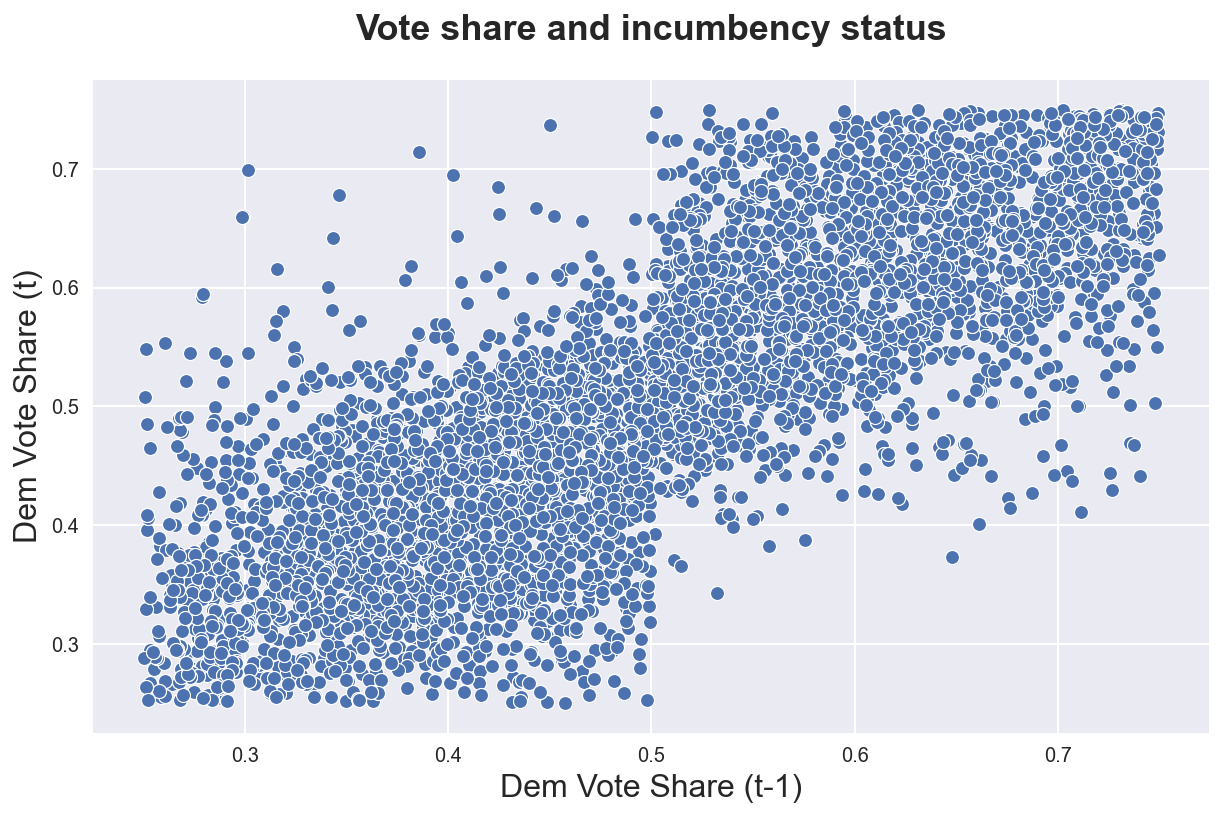

In [5]:
sns.scatterplot(df['lagdemvoteshare'], df['demvoteshare'])\
.set(title='Vote share and incumbency status', xlabel='Dem Vote Share (t-1)', ylabel='Dem Vote Share (t)');

The plot is extremely messy. However we can already see some discontinuity at the threshold: it seems that incumbents do not get vote shares below 0.35. 

To have a more transparent representation of the data, we can use a binscatterplot. Binscatterplots are very similar to histograms with a main difference: instead of having a fixed width, they have a fixed number of observations per bin.

In [6]:
from scipy.stats import binned_statistic

def binscatter(x, y, bins=30, area=True, **kwargs):
    y_bins, x_edges, _ = binned_statistic(x, y, statistic='mean', bins=bins)
    x_bins = (x_edges[:-1] + x_edges[1:]) / 2
    p = sns.scatterplot(x_bins, y_bins, **kwargs)
    if area:
        y_std, _, _ = binned_statistic(x, y, statistic='std', bins=bins)
        plt.fill_between(x_bins, y_bins-y_std, y_bins+y_std, alpha=0.2, color='C0')
    return p

We can now plot the average vote share by previous vote share. The shades represent one standard deviation, at the bin level.

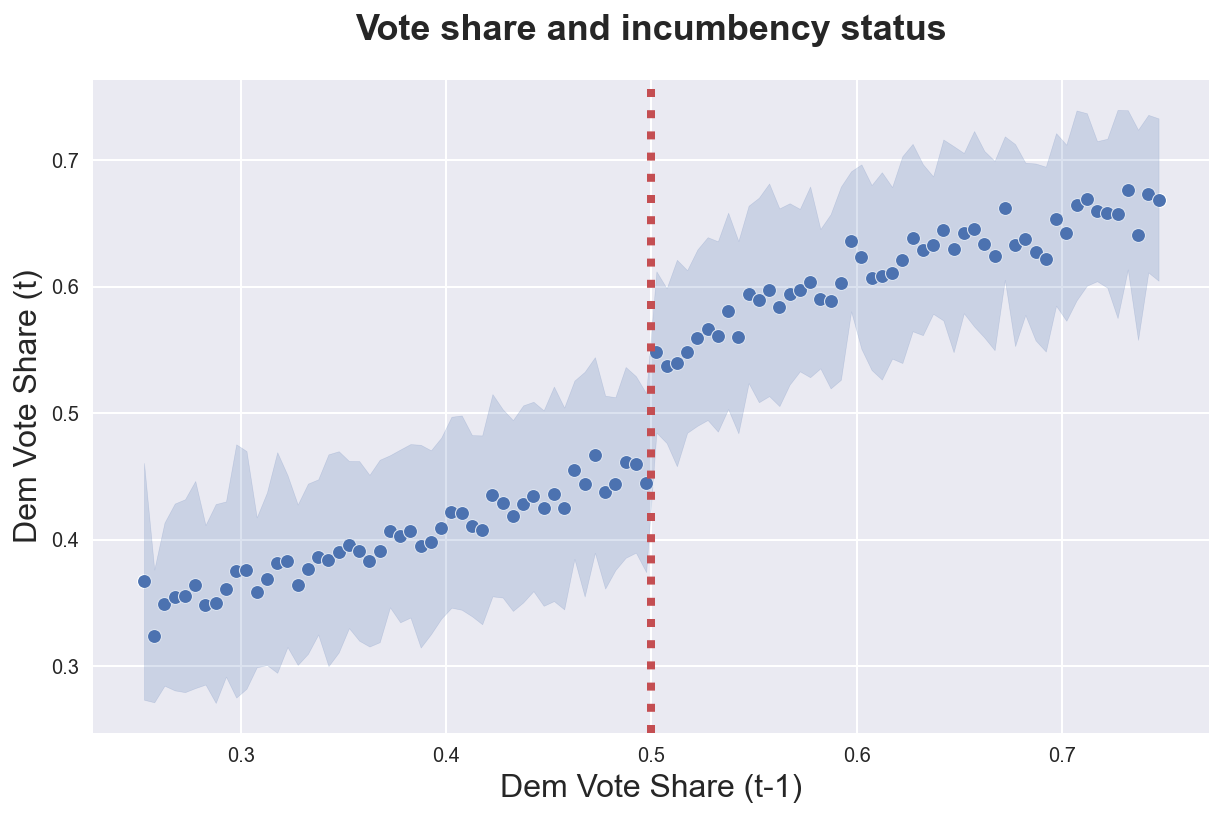

In [7]:
binscatter(df['lagdemvoteshare'], df['demvoteshare'], bins=100)\
.set(title='Vote share and incumbency status', xlabel='Dem Vote Share (t-1)', ylabel='Dem Vote Share (t)');
plt.axvline(x=0.5, ls=":", color='C2');
plt.title('Vote share and incumbency status');

Now it seems quite clear that there exist a discontinuity at $0.5$. We can get a first estimate of the local average treatment effect by assuming a linear model and running a linear regression.

In [8]:
smf.ols('demvoteshare ~ lagdemvoteshare + (lagdemvoteshare>0.5)', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2173,0.005,46.829,0.000,0.208,0.226
lagdemvoteshare > 0.5[T.True],0.0956,0.003,33.131,0.000,0.090,0.101
lagdemvoteshare,0.4865,0.011,42.539,0.000,0.464,0.509


The effect is positive and statistically significant. We can also allow the slope of the line to differ on the two sides of the discontinuity.

In [9]:
df = df.sort_values('lagdemvoteshare')
model = smf.ols('demvoteshare ~ lagdemvoteshare * (lagdemvoteshare>0.5)', df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2256,0.007,34.588,0.000,0.213,0.238
lagdemvoteshare > 0.5[T.True],0.0747,0.012,6.334,0.000,0.052,0.098
lagdemvoteshare,0.4653,0.016,28.547,0.000,0.433,0.497
lagdemvoteshare:lagdemvoteshare > 0.5[T.True],0.0418,0.023,1.827,0.068,-0.003,0.087


Let's plot the predicted vote share over the previous graph.

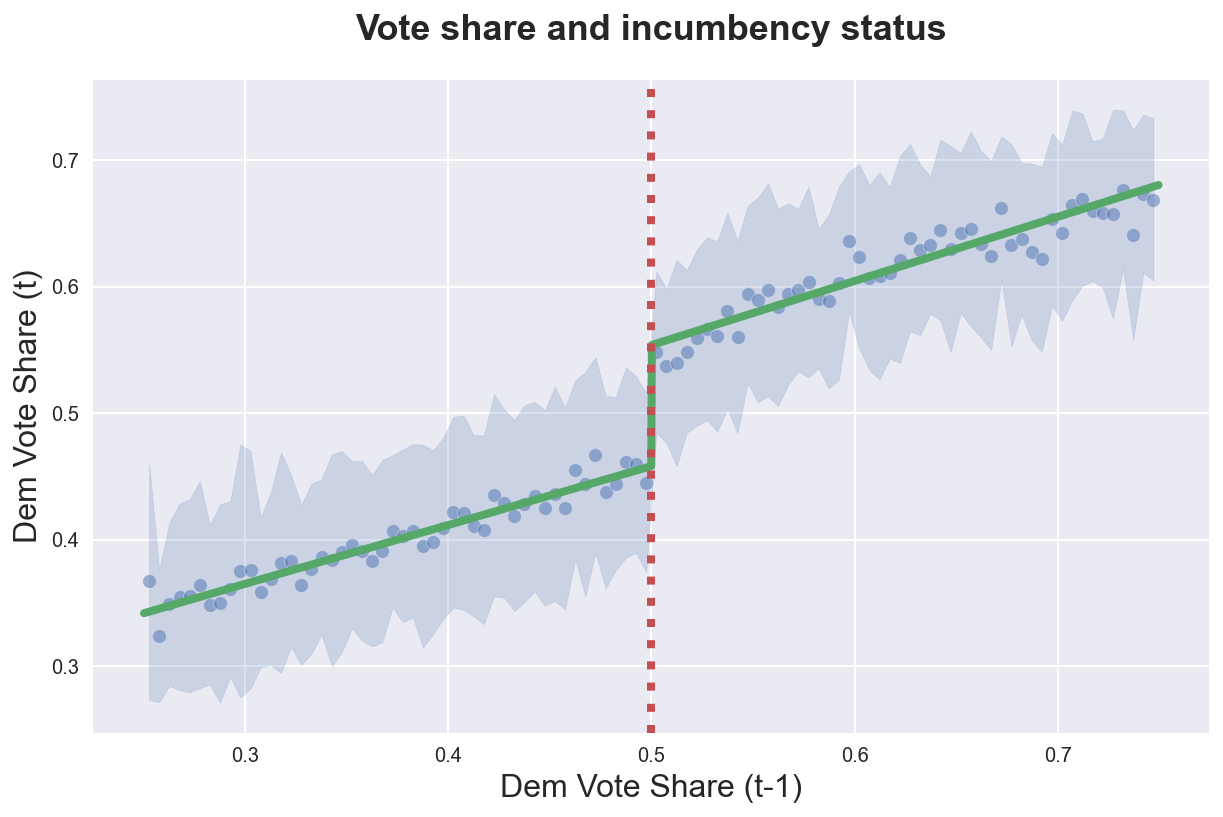

In [14]:
binscatter(df['lagdemvoteshare'], df['demvoteshare'], bins=100, alpha=0.5)\
.set(title='Vote share and incumbency status', xlabel='Dem Vote Share (t-1)', ylabel='Dem Vote Share (t)');
plt.plot(df['lagdemvoteshare'], model.fittedvalues, color='C1')
plt.axvline(x=0.5, ls=":", color='C2');

Now that we have established a discontinuity at the cutoff, we need to check the RD **assumptions**.

First, is there **sorting** across the cutoff? In this case, are democratic politicians more or less likely to lose close elections than republicans? We can plot the distribution of (lagged) vote shares and inspect its shape at the cutoff.

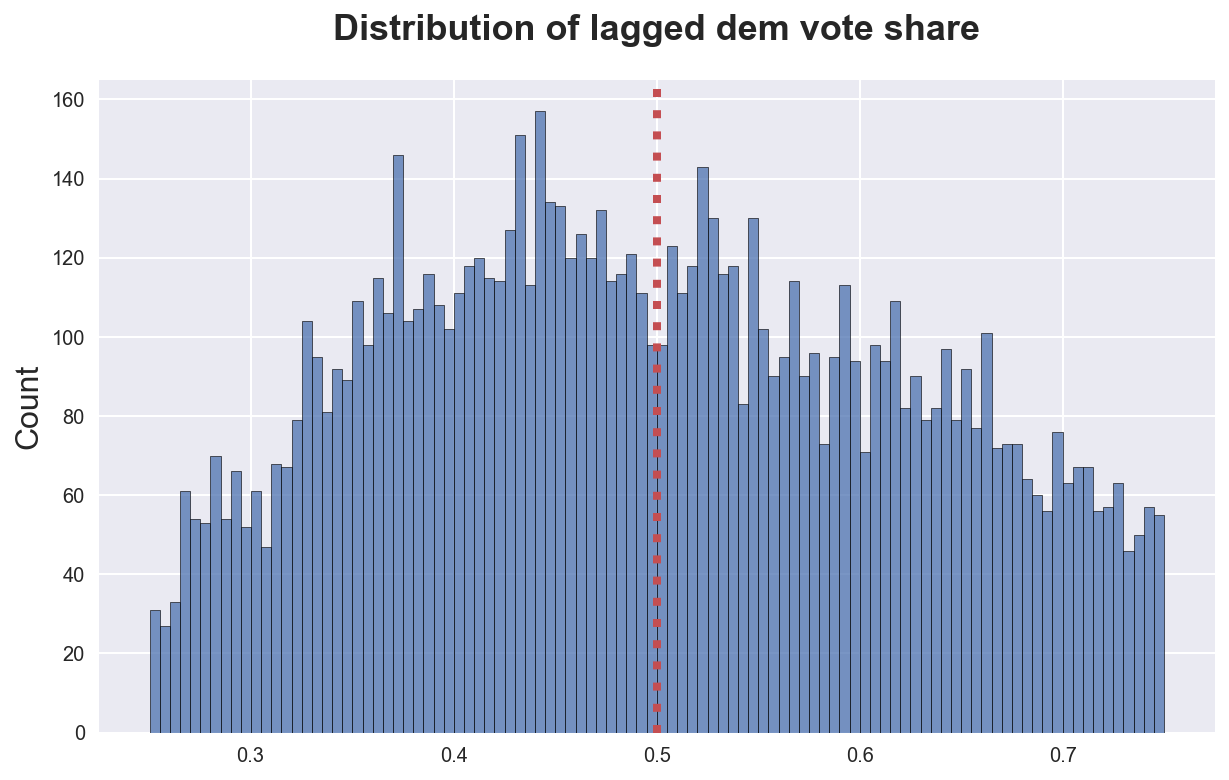

In [11]:
sns.histplot(df['lagdemvoteshare'], bins=100)\
.set(title='Distribution of lagged dem vote share', xlabel='')
plt.axvline(x=0.5, ls=":", color='C2');

If looks pretty smooth. If anything, there is a loss of density at the cutoff, plausibly indicating stronger competition when the competition is close. However, if does not seem particularly asymmetric.

A **placebo** test that we can run is to check if the forcing variable has an effect on variables on which we do not expect to have an effect. In this setting, the most intuitive placebo outcome is previous elections: we do not expect that being on either side of the cutoff today is related to any past outcome. 

In our case, we can simply swap the two variables to run the test.

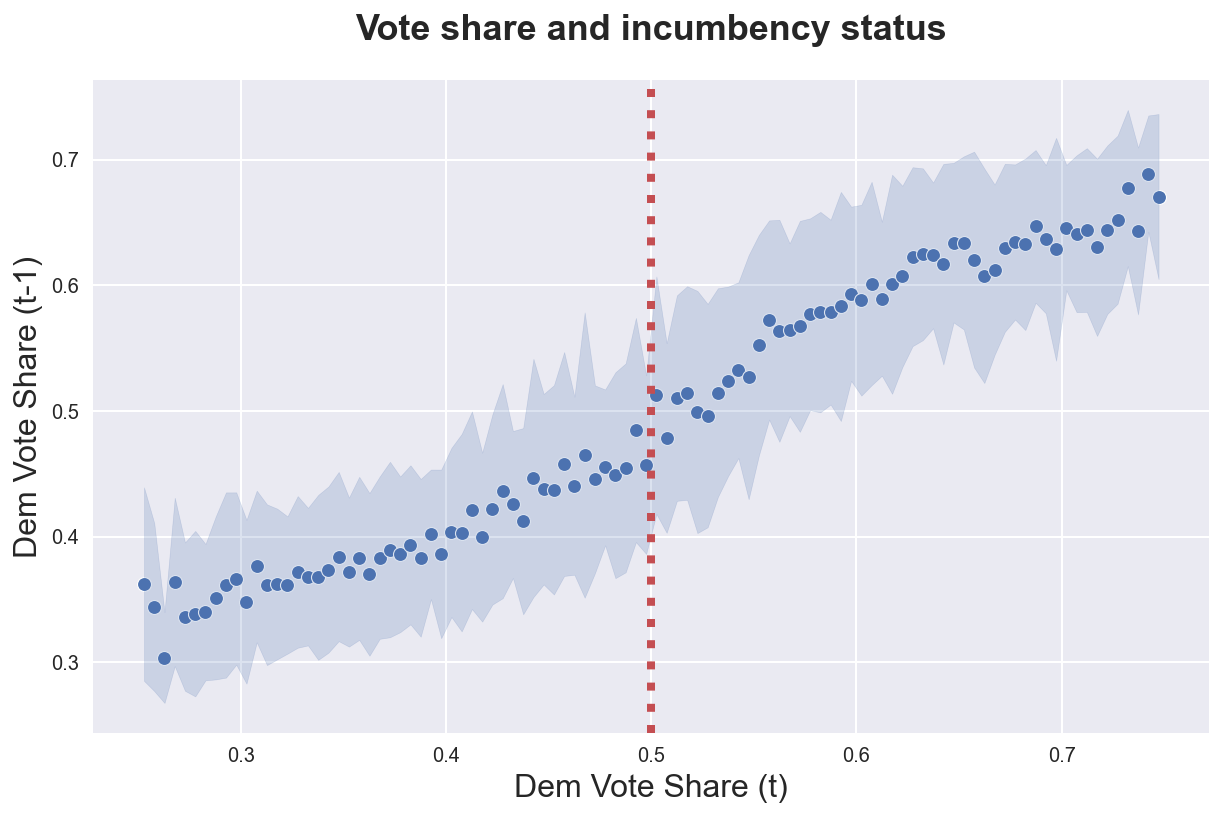

In [12]:
binscatter(df['demvoteshare'], df['lagdemvoteshare'], bins=100)\
.set(title='Vote share and incumbency status', xlabel='Dem Vote Share (t)', ylabel='Dem Vote Share (t-1)');
plt.axvline(x=0.5, ls=":", color='C2');

The distribution of vote shares in the past period does not seem to be discontinuous in the incumbency status today, as expected.

## References

- [Regression discontinuity video lecture by Paul Goldsmith-Pinkham (Yale)](https://www.youtube.com/watch?v=72KFY8beH0w)